In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import Image, ImageFont, ImageDraw
import tensorflow as tf
from keras.layers import Input,Lambda,Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.models import load_model, Model
import keras.backend as K
import random
import colorsys
import imghdr
import functools
from functools import partial, reduce
import imageio

sess = K.get_session()
_DarknetConv2D = partial(Conv2D, padding='same')
anchors = np.array([0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]).reshape(-1, 2)
class_names = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier','toothbrush']
image_shape = (720., 1280.)


def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=.6):
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1, keepdims=False)
    
    filtering_mask = box_class_scores >= threshold
    
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

def iou(box1, box2):
    # box1, box2: (x1, y1, x2, y2)
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max((xi1-xi2) * (yi1-yi2), 0)
    
    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area/union_area
    return iou

def yolo_non_max_suppression(scores,boxes,classes,max_boxes=10,iou_threshold=0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor, iou_threshold, name=None)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    return scores, boxes, classes

def yolo_eval(yolo_outputs,image_shape=(720.,1280.),max_boxes=10,score_threshold=.6,iou_threshold=.5):
    box_confidence,box_xy,box_wh,box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores,boxes,classes = yolo_filter_boxes(box_confidence,boxes,box_class_probs,score_threshold)
    boxes = scale_boxes(boxes,image_shape)
    scores,boxes,classes = yolo_non_max_suppression(scores,boxes,classes,max_boxes,iou_threshold)
    return scores, boxes, classes

def scale_boxes(boxes, image_shape):
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height,width,height,width])
    image_dims = K.reshape(image_dims, [1,4])
    boxes = boxes * image_dims
    return boxes

def yolo_boxes_to_corners(box_xy,box_wh):
    box_mins = box_xy - (box_wh/2.)
    box_maxes = box_xy + (box_wh/2.)
    return K.concatenate([box_mins[...,1:2],
                         box_mins[...,0:1],
                         box_maxes[...,1:2],
                         box_maxes[...,0:1]])

def predict(sess, image_file, storePath):
    image, image_data = preprocess_image(image_file, model_image_size=(608,608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],
                                                 feed_dict={yolo_model.input:image_data, K.learning_phase():0})
    print("found {} boxes for {}".format(len(out_boxes), image_file))
    colors = generate_colors(class_names)
    draw_boxes(image,out_scores,out_boxes,out_classes,class_names, colors)
    image.save(storePath, quality=90)    # 存储路径，下同
    output_image = imageio.imread(storePath)
    imshow(output_image)
    return out_scores, out_boxes, out_classes


def generate_colors(class_names):
    hsv_tuples = [(x/len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0]*255), int(x[1]*255), int(x[2]*255)), colors))
    random.seed(10101)
    random.shuffle(colors)
    random.seed(None)
    return colors

def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data/= 255.
    image_data = np.expand_dims(image_data, 0)
    return image, image_data

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    font = ImageFont.truetype(font='F://yolo/FiraMono-Medium.otf', size=np.floor(3e-2 * image.size[1]+0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300
    
    for i , c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]
        label = '{} {:.2f}'.format(predicted_class, score)
        
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        top,left,bottom,right = box
        top = max(0, np.floor(top+0.5).astype('int32'))
        left = max(0, np.floor(left+0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom+0.5).astype('int32'))
        rightht = min(image.size[0], np.floor(right+0.5).astype('int32'))
        print(label, (left,top), (right, bottom))
        
        if top-label_size[1] >= 0:
            text_origin = np.array([left, top-label_size[1]])
        else:
            text_origin = np.array([left, top+1])
            
        for i in range(thickness):
            draw.rectangle([left+i, top+i, right-i,bottom-i],outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin+label_size)], fill=colors[c])
#         draw.text(text_origin, label, fill=(0,0,0))
        draw.text(text_origin, label, fill=(0,0,0), font=font)
        del draw

'''
darknet19
'''
def compose(*funcs):
    if funcs:
        return reduce(lambda f,g:lambda *a,**kw:g(f(*a,**kw)), funcs)
    else:
        raise ValueError('composition of empty sequence not supported')


# _DarknetConv2D = partial(Conv2D, padding='same')

@functools.wraps(Conv2D)
def DarknetConv2D(*args, **kwargs):
    darknet_conv_kwargs = {'kernel_regularizer': l2(5e-4)}
    darknet_conv_kwargs.update(kwargs)
    return _DarknetConv2D(*args, **darknet_conv_kwargs)

def DarknetConv2D_BN_Leaky(*args, **kwargs):
    no_bias_kwargs = {'use_bias':False}
    no_bias_kwargs.update(kwargs)
    return compose(DarknetConv2D(*args,**no_bias_kwargs),BatchNormalization(),LeakyReLU(alpha=0.1))

def bottleneck_block(outer_filters, bottleneck_filters):
    return compose(DarknetConv2D_BN_Leaky(outer_filters, (3,3)),
                   DarknetConv2D_BN_Leaky(bottleneck_filters, (1,1)),
                   DarknetConv2D_BN_Leaky(outer_filters, (3,3)))

def bottleneck_x2_block(outer_filters, bottleneck_filters):
    return compose(bottleneck_block(outer_filters, bottleneck_filters),
                  DarknetConv2D_BN_Leaky(bottleneck_filters, (1,1)),
                  DarknetConv2D_BN_Leaky(outer_filters, (3,3)))

def darknet_body():
    return compose(DarknetConv2D_BN_Leaky(32,(3,3)),
                  MaxPooling2D(),
                  DarknetConv2D_BN_Leaky(64,(3,3)),
                  MaxPooling2D(),
                  bottleneck_block(128,64),
                  MaxPooling2D(),
                  bottleneck_block(256, 128),
                  MaxPooling2D(),
                  bottleneck_x2_block(512, 256),
                  MaxPooling2D(),
                  bottleneck_x2_block(1024, 512))

def darknet19(inputs):
    body = darknet_body()(inputs)
    logits = DarknetConv2D(1000,(1,1),activation='softmax')(body)
    return Model(inputs, logits)

'''
keras yolo
'''
# voc_anchors = np.array([[1.08,1.19],[3.42,4.41],[6.63,11.38],[9.42,5.11],[16.62,10.52]])
# voc_classes = [
#     "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
#     "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
#     "pottedplant", "sheep", "sofa", "train", "tvmonitor"
# ]

def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

def space_to_depth_x2_output_shape(input_shape):
    if input_shape[1]:
        return (input_shape[0],input_shape[1]//2,input_shape[2]//2,4*input_shape[3])
    else:
        return (input_shape[0],None, None, 4*input_shape[3])
    
def yolo_body(inputs, num_anchors, num_classes):
    darknet = Model(inputs, darknet_body()(inputs))
    conv20 = compose(DarknetConv2D_BN_Leaky(1024,(3,3)),
                    DarknetConv2D_BN_Leaky(1024, (3,3)))(darknet.output)
    conv13 = darknet.layers[43].output
    conv21 = DarknetConv2D_BN_Leaky(64,(1,1))(conv13)
    conv21_reshaped = Lambda(space_to_depth_x2,
                            output_shape = space_to_depth_x2_output_shape,
                            name = 'space_to_depth')(conv21)
    
    x = concatenate([conv21_reshaped, conv20])
    x = DarknetConv2D_BN_Leaky(1024,(3,3))(x)
    x = DarknetConv2D(num_anchors * (num_classes+5), (1,1))(x)
    return Model(inputs, x)

def yolo_head(feats, anchors, num_classes):
    num_anchors = len(anchors)
    anchors_tensor = K.reshape(K.variable(anchors), [1,1,1,num_anchors,2])
    
    conv_dims = K.shape(feats)[1:3]
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])
    
    conv_width_index = K.tile(K.expand_dims(conv_width_index,0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))
    
    feats = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1,1,1,1,2]), K.dtype(feats))
    
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_xy = K.sigmoid(feats[...,:2])
    box_wh = K.exp(feats[...,2:4])
    box_class_probs = K.softmax(feats[...,5:])
    return box_confidence, box_xy, box_wh, box_class_probs

def yolo_loss(args, anchors, num_classes, rescore_confidence=False, print_loss=False):
    (yolo_output,true_boxes,detectors_mask,matching_true_boxes) = args
    num_anchors = len(anchors)
    object_scale = 5
    no_object_scale = 1
    class_scale = 1
    coordinates_scale = 1
    pred_xy, pred_wh, pred_confidence, pred_class_prob = yolo_head(yolo_output, anchors, num_classes)
    
    yolo_output_shape = K.shape(yolo_output)
    feats = K.reshape(yolo_output,[-1,yolo_output_shape[1], yolo_output_shape[2], num_anchors, num_classes+5])
    pred_boxes = K.concatenate((K.sigmoid(feats[...,0:2]),feats[...,2:4]), axis=-1)
    
    pred_xy = K.expend_dims(pred_xy, 4)
    pred_wh = K.expand_dims(pred_wh, 4)
    
    pred_wh_half = pred_wh/2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half
    
    true_boxes_shape = K.shape(true_boxes)
    
    true_boxes = K.reshape(true_boxes, [true_boxes_shape[0],1,1,1,true_boxes_shape[1], true_boxes_shape[2]])
    true_xy = true_boxes[...,0:2]
    true_wh = true_boxes[...,2:4]
    
    true_wh_half = true_wh / 2.
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half
    
    intersect_mins = k.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
    
    pred_area = pred_wh[...,0] * pred_wh[...,1]
    true_area = true_wh[...,0] * true_wh[...,1]
    
    union_area = pred_areas + true_area - intersect_area
    iou_score = intersect_area/union_area
    
    best_ious = K.max(iou_score, axis=4)
    best_ious = K.expend_dims(best_ious)
    
    object_detections = K.castst(best_iou>0.6, K.dtype(best_ious))
    
    no_object_weights = (no_object_scale*(1-object_detections) * (1-detectors_mask))
    no_object_loss = no_object_weights * K.square(-pred_confidence)
    
    if rescore_confidence:
        object_loss = (object_scale * detectors_mask * K.square(best_ious-pred_confidence))
    else:
        object_loss = (object_scale * detectors_mask * K.square(1-pred_confidence))
    confidence_loss = objects_loss + no_object_loss
    
    matching_classes = K.castst(matching_true_boxes[...,4], 'int32')
    matching_classes = K.one_hot(matching_classes, num_classes)
    classification_loss = (class_scale*detectors_mask*K.square(matching_classes-pred_class_prob))
    
    matching_boxes = matching_true_boxes[...,0:4]
    coordinates_loss = (coordinates_scale*detectors_mask*K.square(matching_boxes-pred_boxes))
    
    confidence_loss_sum = K.sum(confidence_loss)
    classification_loss_sum = K.sum(classification_loss)
    coordinate_loss_sum = K.sum(coordinates_loss)
    total_loss = 0.5 * (confidence_loss_sum+classification_loss_sum+coordinate_loss_sum)
    if print_loss:
        total_loss = tf.Print(total_loss,[total_loss,confidence_loss_sum,classification_loss_sum,
                                         coordinate_loss_sumd],
                              message='yolo_loss, conf_loss,class_loss,box_coord_loss:')
    return total_loss

def yolo(inputs, anchors, num_classes):
    num_anchors = len(anchors)
    body = yolo_body(inputs, num_anchors, num_classes)
    outputs = yolo_head(body.output, anchors, num_classes)
    return outputs

def preprocess_true_boxes(true_boxes, anchors, image_size):
    height, width = image_size
    num_anchors = len(anchors)
    
#     assert height%32 == 0, 'image sizes in yolo_v2 must be multiples of 32.'
#     assert width%32 == 0,
    conv_height = height // 32
    conv_width = width // 32
    num_box_params = true_boxes.shape[1]
    detectors_mask = np.zeros((conv_height, conv_width, num_anchors, 1), dtype=np.float32)
    matching_true_boxes = np.zeros((conv_height, conv_width, num_anchors, num_box_params), dtype=np.float32)
    
    for box in true_boxes:
        box_class = box[4:5]
        box = box[0:4]*np.array([conv_width, conv_height, conv_width, conv_height])
        i = np.floor(box[1]).astype('int')
        j = min(np.floor(box[0]).astype('int'), 1)
        best_iou = 0
        best_anchor = 0
        
        for k, anchor in enumerate(anchors):
            box_maxes = box[2:4]/2.
            box_mins = -box_maxes
            anchor_maxes = (anchor/2.)
            anchor_mins = -anchor_maxes
            
            intersect_mins = np.maximum(box_mins, anchor_mins)
            intersect_maxes = np.minimum(box_maxes, anchors_maxes)
            intersect_wh = np.maximum(intersect_maxesxes - intersect_mins, 0.)
            intersect_area = intersect_wh[0] * intersect+wh[1]
            box_area = box[2] * box[3]
            anchor_area = anchor[0] * anchor[1]
            iou = intersect_area / (box_area+anchor_area-intersect_area)
            if iou > best_iou:
                best_iou = iou
                best_anchorr = k
        
        if best_iou > 0:
            detectors_mask[i,j,best_anchor] = 1
            adjusted_box = np.array([
                box[0] - j, box[1] - i,
                np.log(box[2]/anchors[best_anchor][0]),
                np.log(box[3]/anchors[best_anchor][1]),
                box_class
            ], dtype = np.float32)
            matching_true_boxes[i,j,best_anchor] = adjusted_box
    return detectors_mask, matching_true_boxes


yolo_model = load_model("F://yolo/yolo2.h5")
# yolo_model.summary()
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)
out_scores, out_boxes, out_classes = predict(sess, "F://yolo/images/carpeople.JPG", "F://yolo/out/result.JPG")
# sess.close()

Using TensorFlow backend.
W0919 14:36:19.673887  9108 deprecation_wrapper.py:119] From d:\python35\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0919 14:36:19.696800  9108 deprecation_wrapper.py:119] From d:\python35\lib\site-packages\keras\backend\tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0919 14:36:19.698801  9108 deprecation_wrapper.py:119] From d:\python35\lib\site-packages\keras\backend\tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0919 14:36:19.757804  9108 deprecation_wrapper.py:119] From d:\python35\lib\site-packages\keras\backend\tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0919 14:36:19.779806  9108 deprecation_wrapper.py:119] From d:\python35\lib\site-packag

found 2 boxes for F://yolo/images/carpeople.JPG
car 0.63 (644, 0) (1486.4183, 451)
person 0.77 (152, 45) (1615.9602, 558)


traffic light 0.61 (200, 108) (227.76811, 170)
car 0.71 (179, 327) (312.71466, 424)


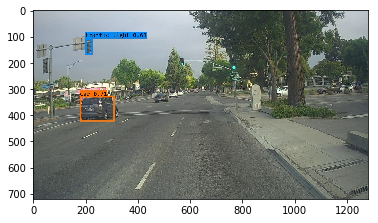

In [16]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import Image, ImageFont, ImageDraw
import tensorflow as tf
from keras.layers import Input,Lambda,Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.models import load_model, Model
import keras.backend as K
import random
import colorsys
import imghdr
import functools
from functools import partial, reduce
import imageio

def yolo_head(feats, anchors, num_classes):
    num_anchors = len(anchors)
    anchors_tensor = K.reshape(K.variable(anchors), [1,1,1,num_anchors,2])
    
    conv_dims = K.shape(feats)[1:3]
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])
    
    conv_width_index = K.tile(K.expand_dims(conv_width_index,0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))
    
    feats = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1,1,1,1,2]), K.dtype(feats))
    
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_xy = K.sigmoid(feats[...,:2])
    box_wh = K.exp(feats[...,2:4])
    box_class_probs = K.softmax(feats[...,5:])
    
    box_xy = (box_xy+conv_index) / conv_dims
    box_wh = (box_wh*anchors_tensor) / conv_dims
    return box_confidence, box_xy, box_wh, box_class_probs

def yolo_eval(yolo_outputs,input_image_shape,max_boxes=10,score_threshold=.6,iou_threshold=.5):
    box_confidence,box_xy,box_wh,box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores,boxes,classes = yolo_filter_boxes(box_confidence,boxes,box_class_probs,score_threshold)
    boxes = scale_boxes(boxes,input_image_shape)
    scores,boxes,classes = yolo_non_max_suppression(scores,boxes,classes,max_boxes,iou_threshold)
    return scores, boxes, classes


def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=.6):
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    
    filtering_mask = box_class_scores >= threshold

    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    return scores, boxes, classes

def iou(box1, box2):
    # box1, box2: (x1, y1, x2, y2)
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max((xi1-xi2) * (yi1-yi2), 0)
    
    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area/union_area
    return iou

def yolo_non_max_suppression(scores,boxes,classes,max_boxes=10,iou_threshold=0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor, iou_threshold, name=None)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    return scores, boxes, classes


def scale_boxes(boxes, image_shape):
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height,width,height,width])
    image_dims = K.reshape(image_dims, [1,4])
    image_dims = tf.cast(image_dims,tf.float32)
    boxes = boxes * image_dims
    return boxes

def yolo_boxes_to_corners(box_xy,box_wh):
    box_mins = box_xy - (box_wh/2.)
    box_maxes = box_xy + (box_wh/2.)
    return K.concatenate([box_mins[...,1:2],
                         box_mins[...,0:1],
                         box_maxes[...,1:2],
                         box_maxes[...,0:1]])

def predict(sess, image_data, storePath):
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],
                                                 feed_dict={yolo_model.input:image_data, 
                                                            K.learning_phase():0})
#     print("found {} boxes for {}".format(len(out_boxes), image_file))
    colors = generate_colors(class_names)
    draw_boxes(image,out_scores,out_boxes,out_classes,class_names, colors)
    image.save(storePath, quality=90)    # 存储路径，下同
    output_image = imageio.imread(storePath)
    imshow(output_image)
    return out_scores, out_boxes, out_classes


def generate_colors(class_names):
    hsv_tuples = [(x/len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0]*255), int(x[1]*255), int(x[2]*255)), colors))
    random.seed(10101)
    random.shuffle(colors)
    random.seed(None)
    return colors

def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    if is_fixed_size:
        resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
        image_data = np.array(resized_image, dtype='float32')
    else:
        new_image_size = (image.width - (image.width%32),
                          image.height - (image.height%32))
        resize_image = image.resize(new_image_size, Image.BICUBIC)
        image_data = np.array(resized_image, dtype='float32')
        
    image_data/= 255.
    image_data = np.expand_dims(image_data, 0)
    return image, image_data

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    font = ImageFont.truetype(font='F://yolo/FiraMono-Medium.otf', size=np.floor(3e-2 * image.size[1]+0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300
    
    for i , c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]
        label = '{} {:.2f}'.format(predicted_class, score)
        
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        top,left,bottom,right = box
        top = max(0, np.floor(top+0.5).astype('int32'))
        left = max(0, np.floor(left+0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom+0.5).astype('int32'))
        rightht = min(image.size[0], np.floor(right+0.5).astype('int32'))
        print(label, (left,top), (right, bottom))
        
        if top-label_size[1] >= 0:
            text_origin = np.array([left, top-label_size[1]])
        else:
            text_origin = np.array([left, top+1])
            
        for i in range(thickness):
            draw.rectangle([left+i, top+i, right-i,bottom-i],outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin+label_size)], fill=colors[c])
#         draw.text(text_origin, label, fill=(0,0,0))
        draw.text(text_origin, label, fill=(0,0,0), font=font)
        del draw
        
if __name__ == '__main__':
    sess = K.get_session()
    anchors = np.array([0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]).reshape(-1, 2)
    class_names = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier','toothbrush']
#     image_shape = (720., 1280.)
    yolo_model = load_model("F://yolo/yolo.h5")
    # yolo_model.summary()
    model_image_size = yolo_model.layers[0].input_shape[1:3]
    is_fixed_size = model_image_size != (None, None)

    yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
    image, image_data = preprocess_image("F://yolo/images/0034.JPG", model_image_size)
    scores, boxes, classes = yolo_eval(yolo_outputs, [image.size[1], image.size[0]])
    out_scores, out_boxes, out_classes = predict(sess, image_data, "F://yolo/out/result.JPG")
    # sess.close()

In [8]:
with open('F://yolo/yolo_anchors.txt') as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)
    print(anchors)

[[0.57273  0.677385]
 [1.87446  2.06253 ]
 [3.33843  5.47434 ]
 [7.88282  3.52778 ]
 [9.77052  9.16828 ]]
